In [24]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
sns.set_style("darkgrid")

# Numerical Setup

In [169]:
N = 50
M = 20 # Number of measurements 
K = 5 # Number of non-zero  coefficents 
T = 50 # Number of time-steps
sparse_support = np.random.choice(N, K, replace=False) # s locations chosen uniformly at random
A = np.random.normal(0, 1, (M, N)) # measurement matrix

# Time-Independent Numerical Setup

In [139]:
X_jointsupp = np.zeros((N, T))
X_jointsupp[sparse_support,:] = np.random.normal(0, 1, (K,T))
Y_jointsupp = A.dot(X_jointsupp)
max_iter = 5*T

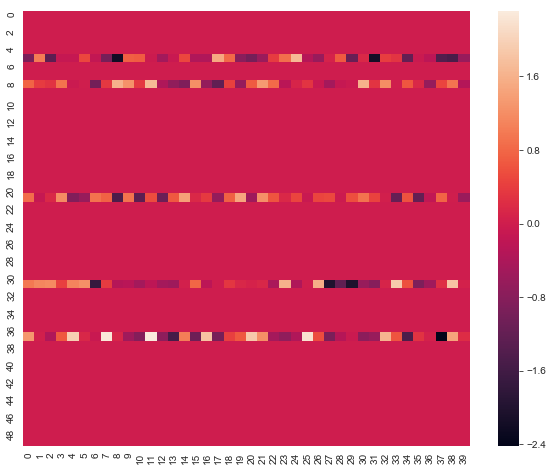

In [93]:
sns.heatmap(X_jointsupp)

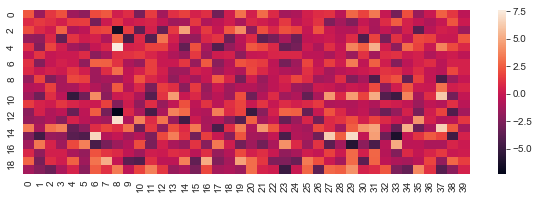

In [95]:
plt.figure(figsize=(10, 3))
sns.heatmap(Y_jointsupp)

# Temporal Correlation Numerical Setup

In [170]:
def get_x_t(t, D_coeffs, z_coeffs, x_0_coeffs):
    if t == 0:
        return x_0_coeffs
    else: 
        return  D_coeffs*get_x_t(t-1, D_coeffs, z_coeffs, x_0_coeffs) + z_coeffs[t]
# Generated via the AR process
def get_x(T, sparse_support):
    K=len(sparse_support)
    x_0_coeffs = sp.random.normal(0, 1, K) 
    D_coeffs = sp.random.uniform(0.8, 1.0, K) # Correlation matrix with diagnonal entries chosen uniformly from [0.8, 1]
    z_coeffs = sp.random.normal(0, (1-D_coeffs**2)[1], (T, K))
    x=[sp.sparse.csr_matrix((get_x_t(t, D_coeffs, z_coeffs, x_0_coeffs), (
        sparse_support, sp.zeros(K))), shape=(N,1)) for t in range(T)]
    return sp.sparse.hstack(x), D_coeffs, z_coeffs

In [171]:
def get_y(x, A, noise=0):    
    return sp.hstack([A*x.tocsc()[:,t] + noise for t in range(x.shape[1])])

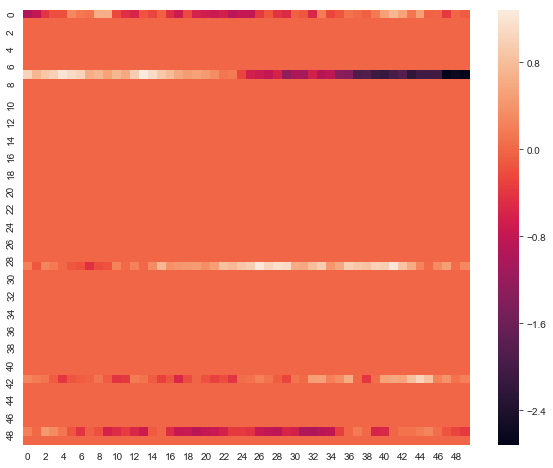

In [172]:
X_tempcorr, D_coeffs, z_coeffs = get_x(T, sparse_support)
sns.heatmap(X_tempcorr.todense())

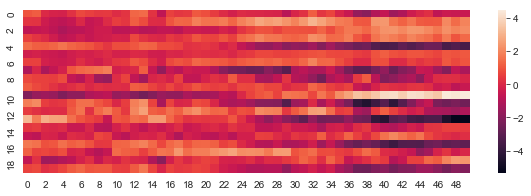

In [173]:
plt.figure(figsize=(10, 3))
Y_tempcorr = get_y(X_tempcorr, A)
sns.heatmap(Y_tempcorr)

# MMV Sparse Randomized Kaczmarz 

In [174]:
# Sparse Randomized kaczmarz algorithm for MMV

# Solve linear system Ax = b

# Inputs: 
#    A: mxn matrix
#    b: mxT vector
#    xSparse: nxT sparse solution to system
#    k: estimate of sparsity of x (setting k = n gives RK)
#    suppX: support of xSparse
#    max_iter: maximum number of iterations
# Outputs:
#    x: estimate of solution
#    err: l2 error
#    supp_rec: percentage of recovered support

# ref. "A Fast Randomized Kaczmarz Algorithm for Sparse Solutions of Consistent Linear Systems"; Mansour, Yilmaz
# Add Anna and Rachel paper

def mmvsrk(A, xSparse, b, k, suppX, max_iter):
    # Initialize     
    m,n = A.shape
    _,T = b.shape 
    fnorm = np.linalg.norm(A, 'fro')**2
    rnorm = np.linalg.norm(A, axis=1)**2
    rowProbs = rnorm/fnorm
    
    X = np.zeros((n,T))
    ktrue = len(suppX)
    supp_rec = []
    err = []
    
    for iter in np.arange(max_iter):
        # Update estimate of support
        supp = np.argsort(np.linalg.norm(X, axis=1)**2, kind='mergesort')[-k:] #take the k greatest 
        
        # weights
        w = (1/np.sqrt(iter+1)) * np.ones(n)
        w[supp] = 1
        
        # choose row
        i = np.random.choice(np.arange(m), p=rowProbs)
        weighted_Ai = w*A[i,:] # weighted row i of A (element-wise product)
        
        # update x
        for tt in np.arange(T):
            dx = ((b[i,tt] - weighted_Ai.dot(X[:,tt]))/np.linalg.norm(weighted_Ai)**2)*weighted_Ai
            X[:,tt] += dx

        # compute metrics
        err +=  [np.linalg.norm(X - xSparse, 'fro')**2/np.linalg.norm(xSparse, 'fro')**2]
        supp_rec += [len(set(suppX).intersection(set(supp)))/float(ktrue)]    

    return X, err, supp_rec

In [175]:
X_smmv, err_smmv, supp_rec_smmv = mmvsrk(A, X_tempcorr.toarray(), Y_tempcorr, 2*K, sparse_support, max_iter)

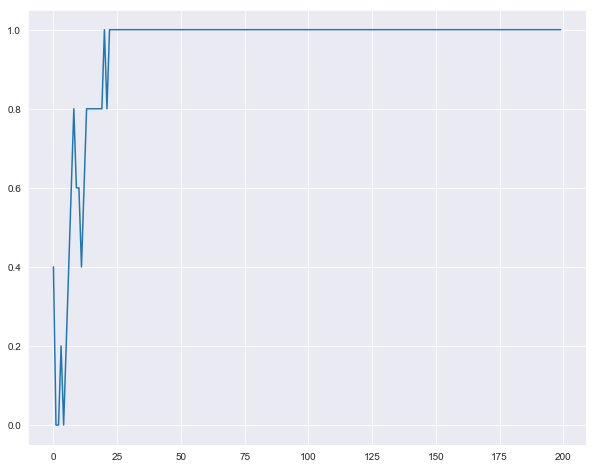

In [176]:
plt.plot(supp_rec_smmv)

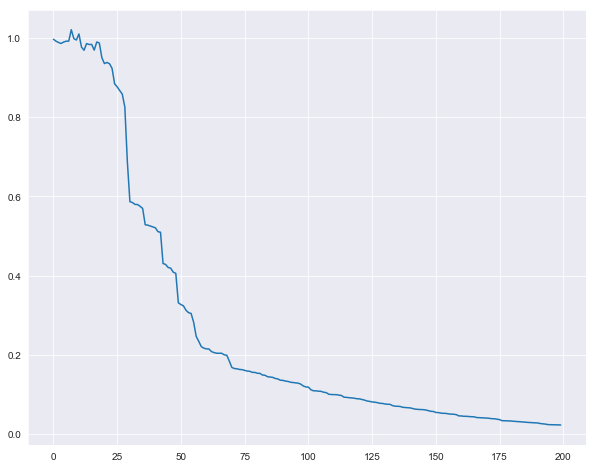

In [177]:
plt.plot(err_smmv)

In [179]:
err_smmv[-1]

0.02266860184276075

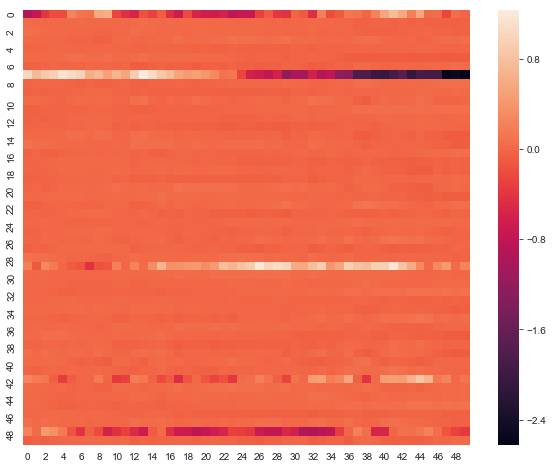

In [180]:
sns.heatmap(X_smmv)

# Online MMV-SRK

In [260]:
def online_mmvsrkv(A, xSparse, b, k, suppX, num_iter = 1):
    # Initialize     
    m,n = A.shape
    _,T = b.shape 
    fnorm = np.linalg.norm(A, 'fro')**2
    rnorm = np.linalg.norm(A, axis=1)**2
    rowProbs = rnorm/fnorm
    
    X = np.zeros((n,T))
    ktrue = len(suppX)
    supp_rec = []
    err = []
    
    # Time-steps are the outer loop
    for t in range(T):
        for i in range(num_iter): 
            # Update estimate of support
            supp = np.argsort(np.linalg.norm(X, axis=1)**2, kind='mergesort')[-k:] #take the k greatest

            # weights
            # Check this weight...too fast? 
            w = (1/np.sqrt((i+t+1))) * np.ones(n)
            w[supp] = 1

            row = np.random.choice(np.arange(m), p=rowProbs)
            weighted_row = w*A[row,:] # weighted row of A (element-wise product)

            # Time-steps we have so far
            # This can be done in parallel and is not inherently sequential
            # should be converted to matrix algebra instead of a for loop
            for tt in range(t+1):

                dx = ((b[row,tt] - weighted_row.dot(X[:,tt]))/np.linalg.norm(weighted_row)**2)*weighted_row
                X[:,tt] += dx

        err +=  [np.linalg.norm(X - xSparse, 'fro')**2/np.linalg.norm(xSparse, 'fro')**2]
        supp_rec += [len(set(suppX).intersection(set(supp)))/float(ktrue)] 
    return X, err, supp_rec

In [287]:
X_on, err_on, supp_rec_on = online_mmvsrkv_tempcorr(A, X_tempcorr.toarray(), Y_tempcorr, 2*K, sparse_support, 10)

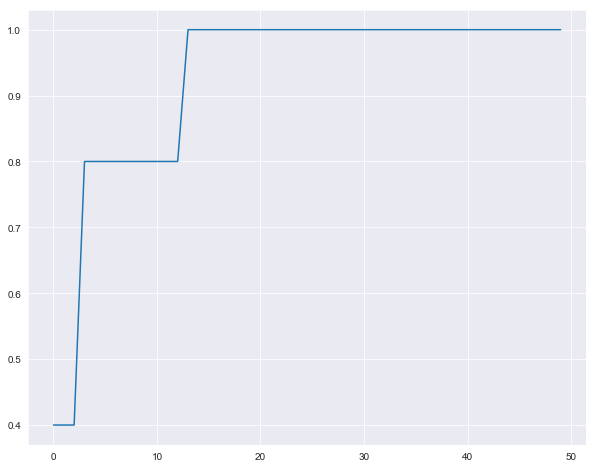

In [288]:
plt.plot(supp_rec_on)

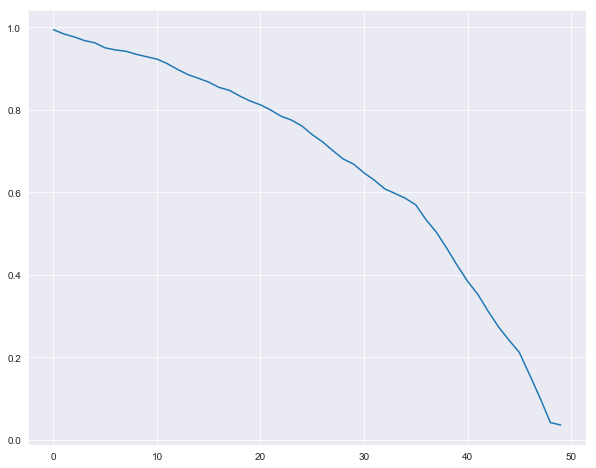

In [289]:
plt.plot(err_on)

In [290]:
err_on[-1]

0.03589095029344171

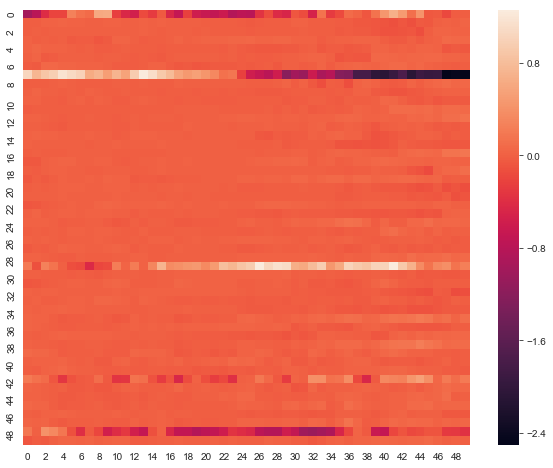

In [291]:
sns.heatmap(X_on)

# Online MMV-SRK with Temporal Correlation Advantage

In [268]:
def online_mmvsrkv_tempcorr(A, xSparse, b, k, suppX, num_iter = 1):
    # Initialize     
    m,n = A.shape
    _,T = b.shape 
    fnorm = np.linalg.norm(A, 'fro')**2
    rnorm = np.linalg.norm(A, axis=1)**2
    rowProbs = rnorm/fnorm
    
    X = np.zeros((n,T))
    ktrue = len(suppX)
    supp_rec = []
    err = []
    
    # Time-steps are the outer loop
    for t in range(T):
        for i in range(num_iter): 
            # Update estimate of support
            supp = np.argsort(np.linalg.norm(X, axis=1)**2, kind='mergesort')[-k:] #take the k greatest

            # weights
            # Check this weight...too fast? 
            w = (1/np.sqrt((i+t+1))) * np.ones(n)
            w[supp] = 1

            row = np.random.choice(np.arange(m), p=rowProbs)
            weighted_row = w*A[row,:] # weighted row of A (element-wise product)

            # Time-steps we have so far
            # This can be done in parallel and is not inherently sequential
            # should be converted to matrix algebra instead of a for loop
            for tt in range(t+1):
                dx = ((b[row,tt] - weighted_row.dot(X[:,tt]))/np.linalg.norm(weighted_row)**2)*weighted_row
                X[:,tt] += dx
        
        # Change the initial estimate of the next signal from zero to the estimate of the current signal
        X[:, min(t+1, T-1)] = X[:, t]
        
        err +=  [np.linalg.norm(X - xSparse, 'fro')**2/np.linalg.norm(xSparse, 'fro')**2]
        supp_rec += [len(set(suppX).intersection(set(supp)))/float(ktrue)] 
    return X, err, supp_rec

In [283]:
X_tc, err_tc, supp_rec_tc = online_mmvsrkv_tempcorr(A, X_tempcorr.toarray(), Y_tempcorr, 2*K, sparse_support, 5)

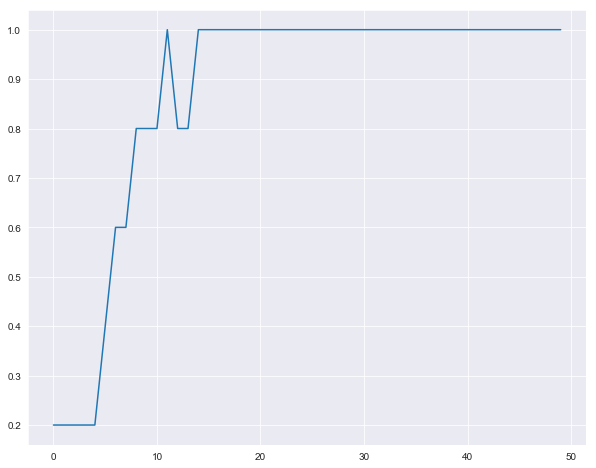

In [284]:
plt.plot(supp_rec_tc)

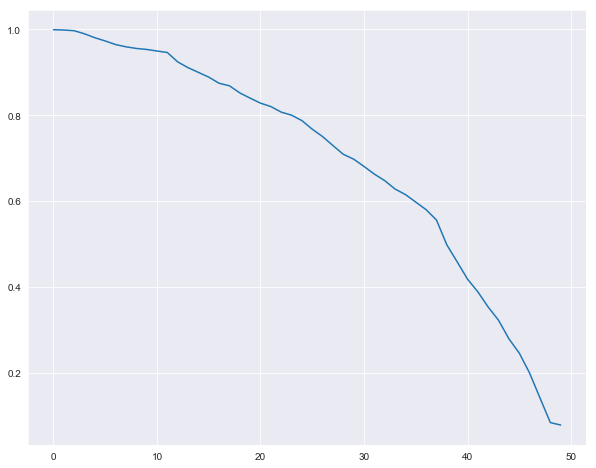

In [285]:
plt.plot(err_tc)

In [286]:
err_tc[-1]

0.07869892577411051

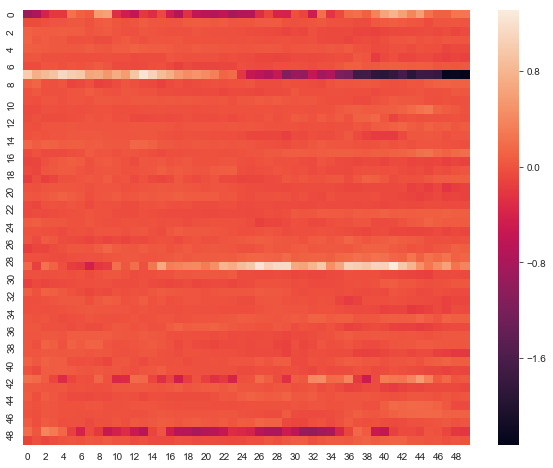

In [292]:
sns.heatmap(X_tc)

# MMV-SRK on Temporally Correlated Signal

First attempt on vanilla MMV-SRK to see if we can use the temporal correlation to our advantage. 

- Run first iteration, get initial (poor) estimate for X
- Run second iteration 
    - update the support estimate based on the row norms...get weighted random measurement vector 
    - update D??
    - update X sequentially, using the previous time and the D to compute the projections
This doesn't seem like it is helping...